<a href="https://colab.research.google.com/github/ZachLuttrell/UCSD_Capstone/blob/main/Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA CLEANING:** *OVERVIEW*

Below is an overview of the steps taken to clean and preprocess the data to prepare it for training.

**STEPS:**
1. Create the training masks at the original resolution.
2. Downsample the image and mask pairs to resemble Sentinel-2 imagery (4m/pix ---> 10m/pix).
3. Patchify training masks and images to create training dataset.
4. Save downsampled imagery and mask pairs for training.

First, let's mount Google Drive to access the dataset.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

root_dir = '/gdrive/My Drive/SpaceNet7'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Next, let's import any additional libraries that we will need.

In [ ]:
!pip install patchify
!pip install geopandas
!pip install rasterio

import multiprocessing
import pandas as pd
import numpy as np
import skimage
from skimage.io import imread
import os
import sys
from patchify import patchify
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio
from rasterio.features import rasterize
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import mapping

print(f'\nLibraries Imported...')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.1 MB/s eta 0:00:00

Libraries Imported...


# Create The Original Training Masks

First, I define a function which will handle the mask creation process.

In [ ]:
  #######
  # NEW #
  #######

import logging

def make_geojsons_and_masks(name_root, image_path, json_path,
                            output_path_mask, output_path_mask_fbc=None):
    try:
        # Setup basic logging
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

        logging.info(f'Processing {name_root}...')

        # Attempt to load GeoJSON data
        try:
            gdf = gpd.read_file(json_path)
        except Exception as e:
            logging.error(f'Error reading GeoJSON file at {json_path}: {e}')
            return

        if gdf.empty:
            logging.warning(f'GeoJSON file at {json_path} is empty. Skipping {name_root}.')
            return

        # Dropping null geometries
        gdf_nonull = gdf.dropna(subset=['geometry'])
        if gdf_nonull.empty or len(gdf_nonull) < len(gdf) * 0.5:  # Arbitrary threshold, adjust based on your needs
            logging.warning(f'Many null geometries dropped or file significantly smaller. Please check {json_path}.')

        # Attempt to open the image file
        try:
            with rasterio.open(image_path) as src:
                meta = src.meta
                image_crs = src.crs
                transform = src.transform
                im_shape = (src.height, src.width)
                image_data = src.read(1)  # Assuming interest in the first band
        except Exception as e:
            logging.error(f'Error reading image file at {image_path}: {e}')
            return

        # Check and transform CRS if necessary
        if gdf_nonull.crs != image_crs:
            logging.info(f'Transforming CRS from {gdf_nonull.crs} to {image_crs}')
            gdf_nonull = gdf_nonull.to_crs(image_crs)

        # After ensuring CRS compatibility and before rasterizing
        logging.info('Checking and fixing invalid geometries...')
        gdf_nonull['geometry'] = gdf_nonull.apply(
            lambda row: row['geometry'].buffer(0) if not row['geometry'].is_valid else row['geometry'], axis=1
        )

        # DEBUG CHECKPOINT
        logging.info('Boundaries:')
        logging.info(f'gdf.total_bounds: {gdf.total_bounds}')
        logging.info(f'src.bounds: {src.bounds}')

        # Generate the masks
        if gdf_nonull.empty:
            logging.info(f"No valid geometries for {name_root}, creating empty masks.")
            mask_arr = np.zeros(im_shape, dtype=np.uint8)
            if output_path_mask_fbc:
                fbc_mask_arr = np.zeros((*im_shape, 3), dtype=np.uint8)  # Three-channel mask for FBC
        else:
            # Rasterize the geometries to create the footprint mask
            footprint_mask = rasterize(
                [(mapping(geom), 255) for geom in gdf_nonull.geometry],
                out_shape=im_shape,
                fill=0,
                transform=transform,  # Ensure geometries are placed correctly according to the image's geotransform
                merge_alg=rasterio.enums.MergeAlg.add,
                dtype=rasterio.uint8)

            if output_path_mask_fbc:
                # Initialize three-channel FBC mask
                fbc_mask_arr = np.stack([footprint_mask, footprint_mask, footprint_mask])

        # Save the masks
        meta.update(dtype=rasterio.uint8, count=1)

        # Save single-channel footprint mask
        with rasterio.open(output_path_mask, 'w', **meta) as dst:
            dst.write(footprint_mask, 1)

        if output_path_mask_fbc:
            # Save three-channel FBC mask
            meta.update(count=3)  # Update meta to reflect three channels
            with rasterio.open(output_path_mask_fbc, 'w', **meta) as dst:
                for i in range(1, 4):
                    dst.write(fbc_mask_arr[i - 1], i)

        logging.info(f'Masks for {name_root} created and saved successfully.')

    except Exception as e:
        logging.error(f'Unexpected error in make_geojsons_and_masks for {name_root}: {e}')

Here, I load in the UDM masked tif imagery and geojson labels in order to create the original training mask images.  These images will be saved to the (TODO) directory for later retrieval.

In [ ]:
# Create Training Masks
# Currently focusing on a single-channel mask, but can edit to support multi-channel masks as well.

# For Tracking Purposes
masks_created = 0

# List all Area of Interest (AOI) directories within the 'train' directory.
aois = sorted([f for f in os.listdir(os.path.join(root_dir, 'train'))
               if os.path.isdir(os.path.join(root_dir, 'train', f))])

params = []
make_fbc = False  # Flag to decide whether to make feature-by-class (fbc) masks, not used here.

input_args = []  # List to store arguments for the parallel processing function.
for i, aoi in enumerate(aois):
    print(i, "aoi:", aoi)  # Print AOI being processed for visibility.

    # Define directories for images, GeoJSON annotations, and output masks.
    im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked/')
    json_dir = os.path.join(root_dir, 'train', aoi, 'labels_match/')
    out_dir_mask = '/gdrive/My Drive/Dataset/original_masks'
    out_dir_mask_fbc = os.path.join(root_dir, 'train', aoi, 'masks_fbc/')

    # Create the output directories if they don't already exist.
    os.makedirs(out_dir_mask, exist_ok=True)
    if make_fbc:
        os.makedirs(out_dir_mask_fbc, exist_ok=True)

    # List all GeoJSON files with building footprints in the current AOI.
    json_files = sorted([f for f in os.listdir(json_dir)
                         if f.endswith('Buildings.geojson') and os.path.exists(os.path.join(json_dir, f))])

    for j, f in enumerate(json_files):
        # Derive the root name of each file for consistency in naming output files.
        name_root = f.split('.')[0]
        # Define paths for the current GeoJSON file, corresponding image, and output mask.
        json_path = os.path.join(json_dir, f)
        image_path = os.path.join(im_dir, name_root + '.tif').replace('labels', 'images').replace('_Buildings', '')
        output_path_mask = os.path.join(out_dir_mask, name_root + '.tif')

        # Prepare for feature-by-class mask creation if flagged, otherwise set to None.
        if make_fbc:
            output_path_mask_fbc = os.path.join(out_dir_mask_fbc, name_root + '.tif')
        else:
            output_path_mask_fbc = None

        # Skip mask creation if it already exists.
        if os.path.exists(output_path_mask):
            continue
        else:
            # Check to make sure image and geojson files exist
            if not os.path.exists(image_path) or not os.path.exists(json_path):
                print(f"Skipping {name_root} due to missing image or GeoJSON")
                continue

            # Append arguments for mask creation to input_args list.
            input_args.append([make_geojsons_and_masks,
                               name_root, image_path, json_path,
                               output_path_mask, output_path_mask_fbc])

            """# Print paths for visibility
            print('Arguments Appended For:')
            print(f'name_root: {name_root}')
            print(f'image_path: {image_path}')
            print(f'json_path: {json_path}')
            print(f'output_path_mask: {output_path_mask}')"""

# SEQUENTIAL EXECUTION OF INPUT ARGS
print("Beginning sequential execution of mask creation...\n")
for args in input_args:
    # Unpack the arguments
    func, name_root, image_path, json_path, output_path_mask, output_path_mask_fbc = args

    # Check if the output mask already exists to avoid redoing work
    if not os.path.exists(output_path_mask):
        print(f"Processing {name_root}...")
        # Call the function with the unpacked arguments
        func(name_root, image_path, json_path, output_path_mask, output_path_mask_fbc)
        print(f"Completed {name_root}.")
        masks_created += 1
    else:
        print(f"Mask for {name_root} already exists, skipping...")

print('RESULTS REPORT:')
print(f'A Total of {masks_created} masks were created for {len(aois)} AOIs.')

0 aoi: L15-0331E-1257N_1327_3160_13
1 aoi: L15-0357E-1223N_1429_3296_13
2 aoi: L15-0358E-1220N_1433_3310_13
3 aoi: L15-0361E-1300N_1446_2989_13
4 aoi: L15-0368E-1245N_1474_3210_13
5 aoi: L15-0387E-1276N_1549_3087_13
6 aoi: L15-0434E-1218N_1736_3318_13
7 aoi: L15-0457E-1135N_1831_3648_13
8 aoi: L15-0487E-1246N_1950_3207_13
9 aoi: L15-0506E-1204N_2027_3374_13
10 aoi: L15-0544E-1228N_2176_3279_13
11 aoi: L15-0566E-1185N_2265_3451_13
12 aoi: L15-0571E-1075N_2287_3888_13
13 aoi: L15-0577E-1243N_2309_3217_13
14 aoi: L15-0586E-1127N_2345_3680_13
15 aoi: L15-0595E-1278N_2383_3079_13
16 aoi: L15-0614E-0946N_2459_4406_13
17 aoi: L15-0632E-0892N_2528_4620_13
18 aoi: L15-0683E-1006N_2732_4164_13
19 aoi: L15-0760E-0887N_3041_4643_13
20 aoi: L15-0924E-1108N_3699_3757_13
21 aoi: L15-0977E-1187N_3911_3441_13
22 aoi: L15-1014E-1375N_4056_2688_13
23 aoi: L15-1015E-1062N_4061_3941_13
24 aoi: L15-1025E-1366N_4102_2726_13
25 aoi: L15-1049E-1370N_4196_2710_13
26 aoi: L15-1138E-1216N_4553_3325_13
27 aoi: L15

Completed global_monthly_2018_10_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2018_11_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...
Completed global_monthly_2018_11_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2018_12_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...
Completed global_monthly_2018_12_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2019_01_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...
Completed global_monthly_2019_01_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2019_02_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...
Completed global_monthly_2019_02_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2019_03_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...
Completed global_monthly_2019_03_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2019_04_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...
Completed global_month

Completed global_monthly_2019_07_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2019_08_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...


Completed global_monthly_2019_08_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2019_09_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...
Completed global_monthly_2019_09_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2019_10_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...
Completed global_monthly_2019_10_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2019_11_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...


Completed global_monthly_2019_11_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2019_12_mosaic_L15-0457E-1135N_1831_3648_13_Buildings...
Completed global_monthly_2019_12_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.
Processing global_monthly_2018_01_mosaic_L15-0487E-1246N_1950_3207_13_Buildings...
Completed global_monthly_2018_01_mosaic_L15-0487E-1246N_1950_3207_13_Buildings.
Processing global_monthly_2018_02_mosaic_L15-0487E-1246N_1950_3207_13_Buildings...
Completed global_monthly_2018_02_mosaic_L15-0487E-1246N_1950_3207_13_Buildings.
Processing global_monthly_2018_03_mosaic_L15-0487E-1246N_1950_3207_13_Buildings...
Completed global_monthly_2018_03_mosaic_L15-0487E-1246N_1950_3207_13_Buildings.
Processing global_monthly_2018_04_mosaic_L15-0487E-1246N_1950_3207_13_Buildings...
Completed global_monthly_2018_04_mosaic_L15-0487E-1246N_1950_3207_13_Buildings.
Processing global_monthly_2018_05_mosaic_L15-0487E-1246N_1950_3207_13_Buildings...
Completed global_month

Completed global_monthly_2018_03_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2018_04_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...


Completed global_monthly_2018_04_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2018_05_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...


Completed global_monthly_2018_05_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2018_06_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...


Completed global_monthly_2018_06_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2018_07_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...


Completed global_monthly_2018_07_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2018_08_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...


Completed global_monthly_2018_08_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2018_09_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2018_09_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2018_10_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2018_10_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2018_11_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2018_11_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2018_12_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2018_12_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_01_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2019_01_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_02_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_month

Completed global_monthly_2019_04_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_05_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...


Completed global_monthly_2019_05_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_06_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...


Completed global_monthly_2019_06_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_07_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2019_07_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_08_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2019_08_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_09_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2019_09_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_10_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2019_10_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_11_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_monthly_2019_11_mosaic_L15-1848E-0793N_7394_5018_13_Buildings.
Processing global_monthly_2019_12_mosaic_L15-1848E-0793N_7394_5018_13_Buildings...
Completed global_month

**Visual Inspection of Image & Mask Pairs**

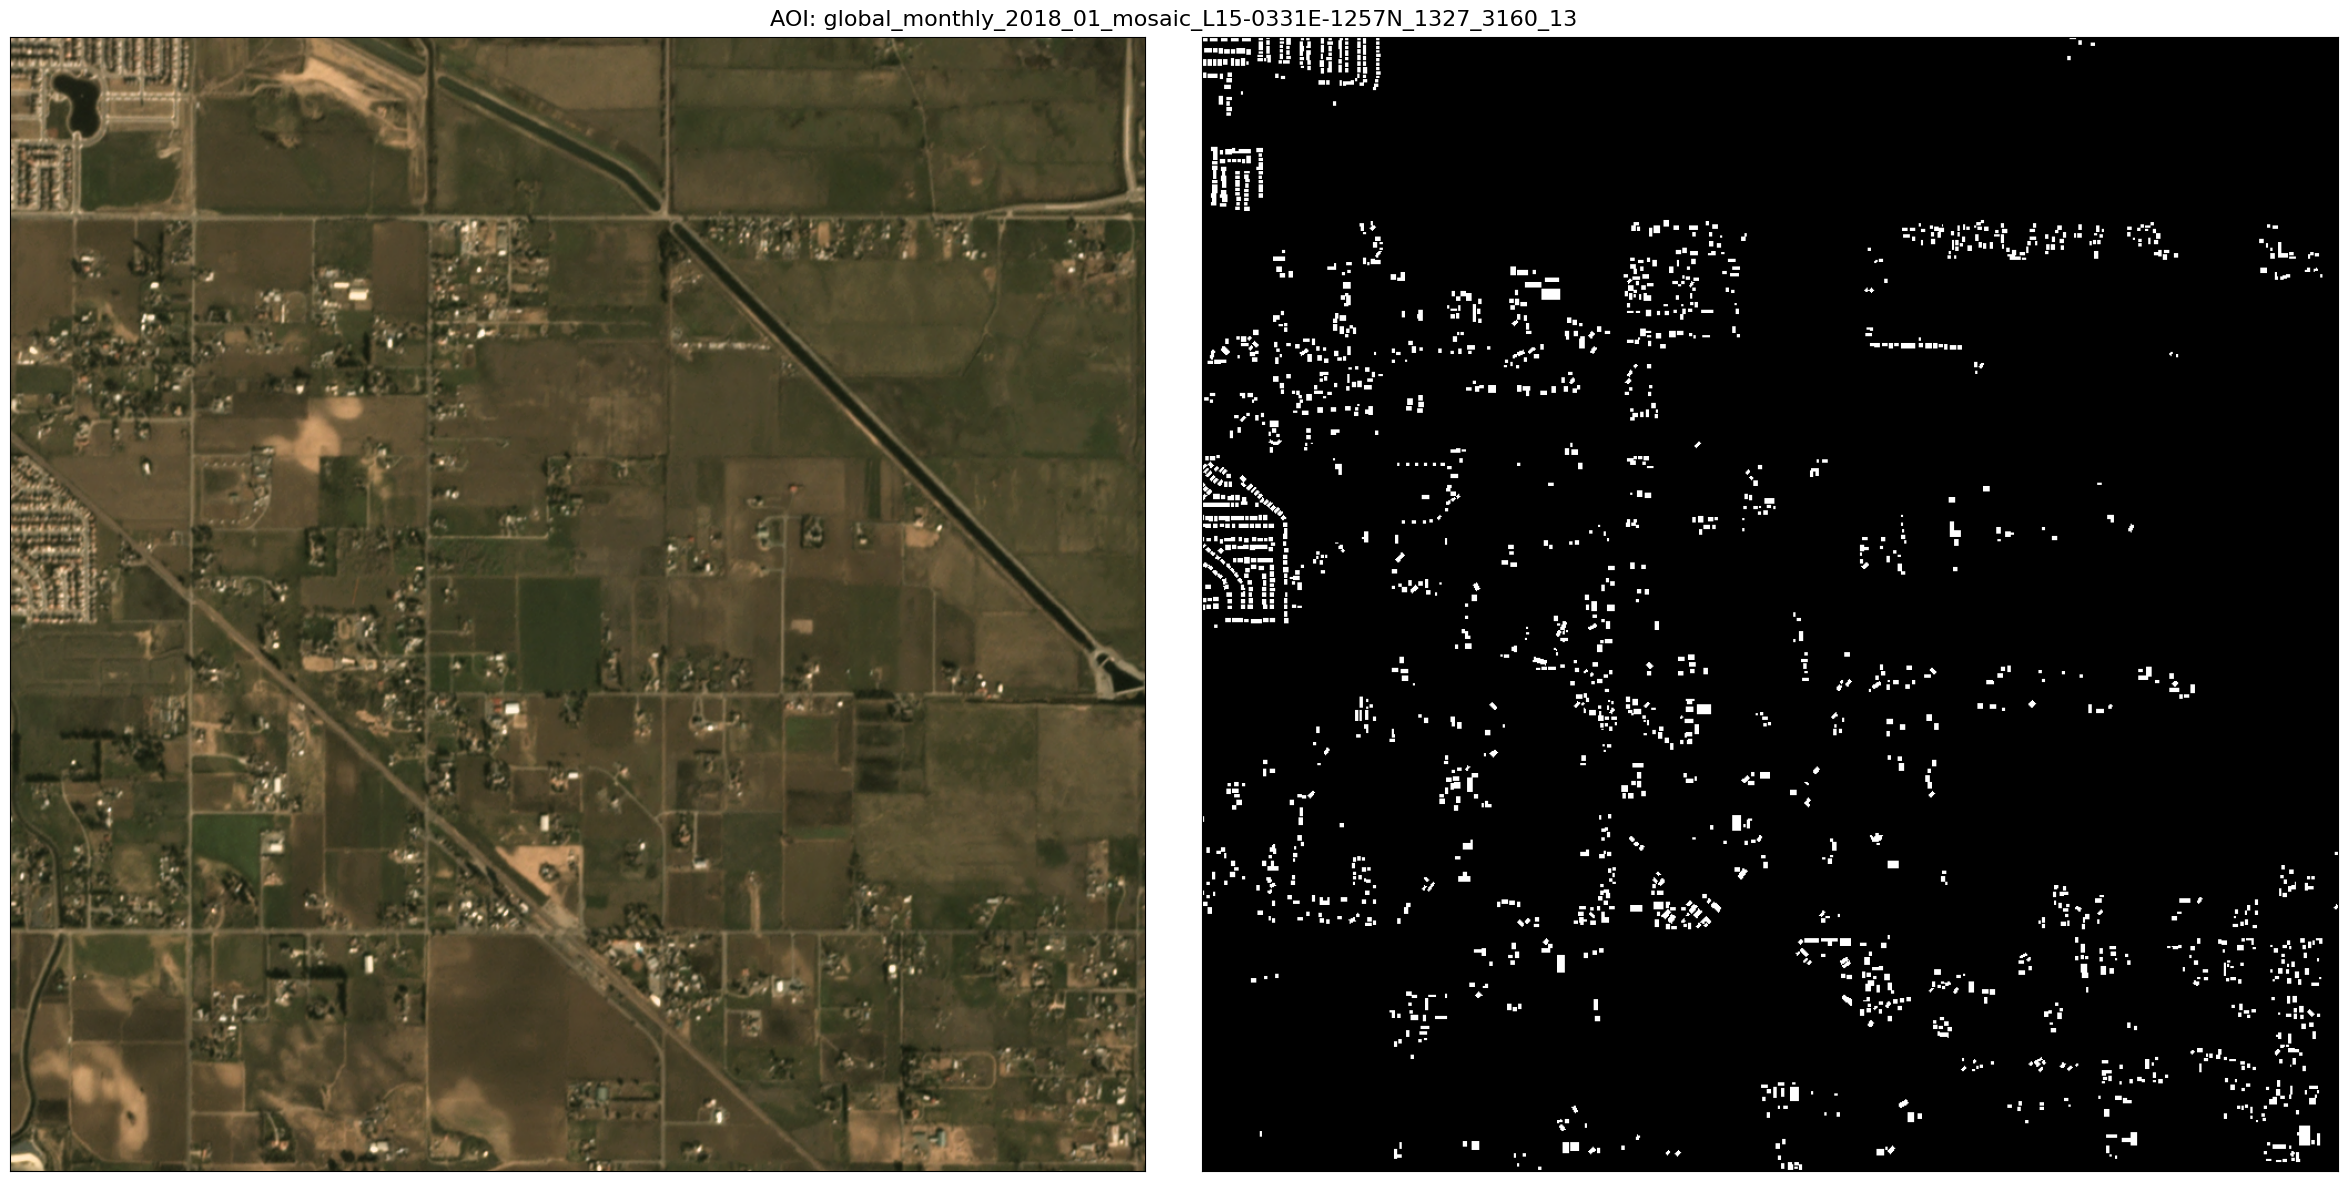

In [ ]:
# Visually inspect the generated masks against the original images.

import os
import skimage.io
import matplotlib.pyplot as plt

# Update root_dir to your Google Drive path if it's not already set
root_dir = '/gdrive/My Drive/SpaceNet7'

# Select an Area of Interest (AOI) for inspection.
aoi = 'L15-0331E-1257N_1327_3160_13'
# Adjust the mask_dir path to where your masks are actually saved.
mask_dir = '/gdrive/My Drive/Dataset/original_masks'  # Updated path

# Define directory for the masked images within the selected AOI.
im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked')

# List all .tif files in the images directory and select the first one for demonstration.
im_list = sorted([z for z in os.listdir(im_dir) if z.endswith('.tif')])
im_file = im_list[0]

# Correctly define im_path and adjust mask_path to match the naming convention.
im_path = os.path.join(im_dir, im_file)
mask_filename = im_file.split('.')[0] + '_Buildings.tif'
mask_path = os.path.join(mask_dir, mask_filename)

# Read the image and mask using skimage.io.imread.
im = skimage.io.imread(im_path)
mask = skimage.io.imread(mask_path)

# Visualization setup
figsize = (24, 12)
name = im_file.split('.')[0]  # Simplified for demonstration

# Create subplots for displaying the image and mask side by side.
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
# Display the original image
_ = ax0.imshow(im)
ax0.set_xticks([])
ax0.set_yticks([])

# Display the mask
_ = ax1.imshow(mask, cmap='gray')  # Added cmap='gray' for clarity in mask visualization
ax1.set_xticks([])
ax1.set_yticks([])

# Title and layout adjustment
_ = fig.suptitle(f'AOI: {name}', fontsize=16)
plt.tight_layout()
plt.show()


# Downsample Image and Mask Pairs to 10m Resolution

Here I downsample both the mask images and their corresponding imagery pairs to 10m resolution.  This is crucial for training the model to predict on Sentinel 2 imagery which has a native resolution of 10m. These downsampled images will be saved to the Dataset/downsampling/images & Dataset/downsampling/masks directories for further use.

In [ ]:
import rasterio
from rasterio.enums import Resampling

def downsample_image(input_path, output_path, scale_factor, resampling=Resampling.bilinear):
    """
    Downsamples an image or mask to a specified scale factor with a given resampling method.

    Args:
    - input_path: Path to the input image or mask.
    - output_path: Path where the downsampled image or mask will be saved.
    - scale_factor: Scale factor to downsample by (e.g., 0.4 for downsampling from 4m/pixel to 10m/pixel).
    - resampling: Method of resampling (default is Resampling.bilinear).
    """
    with rasterio.open(input_path) as src:
        # Calculate the new dimensions.
        new_width = int(src.width * scale_factor)
        new_height = int(src.height * scale_factor)

        # Perform the downsampling.
        data = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=resampling
        )

        # Update the metadata to reflect the new resolution.
        transform = src.transform * src.transform.scale(
            (src.width / data.shape[-1]),
            (src.height / data.shape[-2])
        )
        new_meta = src.meta.copy()
        new_meta.update({
            "driver": "GTiff",
            "height": new_height,
            "width": new_width,
            "transform": transform
        })

        # Write the downsampled image to disk.
        with rasterio.open(output_path, "w", **new_meta) as dst:
            dst.write(data)

        print(f"Downsampled file saved to {output_path}")

In [ ]:
import os
from pathlib import Path

# Set your directories here
downsampled_dir = '/gdrive/My Drive/Dataset/downsampling'  # Target directory for downsampled images/masks
mask_root_dir = '/gdrive/My Drive/Dataset/original_masks'  # Path to the original masks

scale_factor = 4 / 10  # Target resolution

# Ensure the target directories exist
Path(downsampled_dir).mkdir(parents=True, exist_ok=True)

# Iterate through each Area of Interest (AOI)
for aoi in sorted(os.listdir(os.path.join(root_dir, 'train'))):
    if not os.path.isdir(os.path.join(root_dir, 'train', aoi)): continue  # Skip non-directory files

    # Define directories
    im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked')
    downsampled_im_dir = os.path.join(downsampled_dir, 'images', aoi)
    downsampled_mask_dir = os.path.join(downsampled_dir, 'masks', aoi)

    # Ensure target directories exist for the downsampled images and masks
    Path(downsampled_im_dir).mkdir(parents=True, exist_ok=True)
    Path(downsampled_mask_dir).mkdir(parents=True, exist_ok=True)

    # List all image files in the current AOI directory
    for im_file in os.listdir(im_dir):
        if not im_file.endswith('.tif'): continue  # Skip non-TIF files

        # Construct paths for the original image and its downsampled counterpart
        im_path = os.path.join(im_dir, im_file)
        downsampled_im_path = os.path.join(downsampled_im_dir, im_file)

        # Adjust mask filename to include '_Buildings' suffix
        mask_filename = im_file.replace('.tif', '_Buildings.tif')
        mask_path = os.path.join(mask_root_dir, mask_filename)  # Adjusted for mask naming convention
        downsampled_mask_path = os.path.join(downsampled_mask_dir, mask_filename)

        # Downsample the imagery
        if not os.path.exists(downsampled_im_path):  # Check to avoid reprocessing
            print(f"Downsampling image: {im_path}")
            downsample_image(im_path, downsampled_im_path, scale_factor, resampling=Resampling.bilinear)

        # Downsample the mask, checking for its existence first
        if not os.path.exists(downsampled_mask_path) and os.path.exists(mask_path):
            print(f"Downsampling mask: {mask_path}")
            downsample_image(mask_path, downsampled_mask_path, scale_factor, resampling=Resampling.nearest)
        elif not os.path.exists(mask_path):
            print(f"Mask file does not exist for {mask_path}, skipping...")


Streaming output truncated to the last 5000 lines.
Downsampled file saved to /gdrive/My Drive/Dataset/downsampling/images/L15-0457E-1135N_1831_3648_13/global_monthly_2018_01_mosaic_L15-0457E-1135N_1831_3648_13.tif
Downsampling mask: /gdrive/My Drive/Dataset/original_masks/global_monthly_2018_01_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.tif
Downsampled file saved to /gdrive/My Drive/Dataset/downsampling/masks/L15-0457E-1135N_1831_3648_13/global_monthly_2018_01_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.tif
Downsampling image: /gdrive/My Drive/SpaceNet7/train/L15-0457E-1135N_1831_3648_13/images_masked/global_monthly_2018_02_mosaic_L15-0457E-1135N_1831_3648_13.tif
Downsampled file saved to /gdrive/My Drive/Dataset/downsampling/images/L15-0457E-1135N_1831_3648_13/global_monthly_2018_02_mosaic_L15-0457E-1135N_1831_3648_13.tif
Downsampling mask: /gdrive/My Drive/Dataset/original_masks/global_monthly_2018_02_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.tif
Downsampled file saved to /g

**Visual Inspection of Original and Downsampled Image and Mask Pairs**

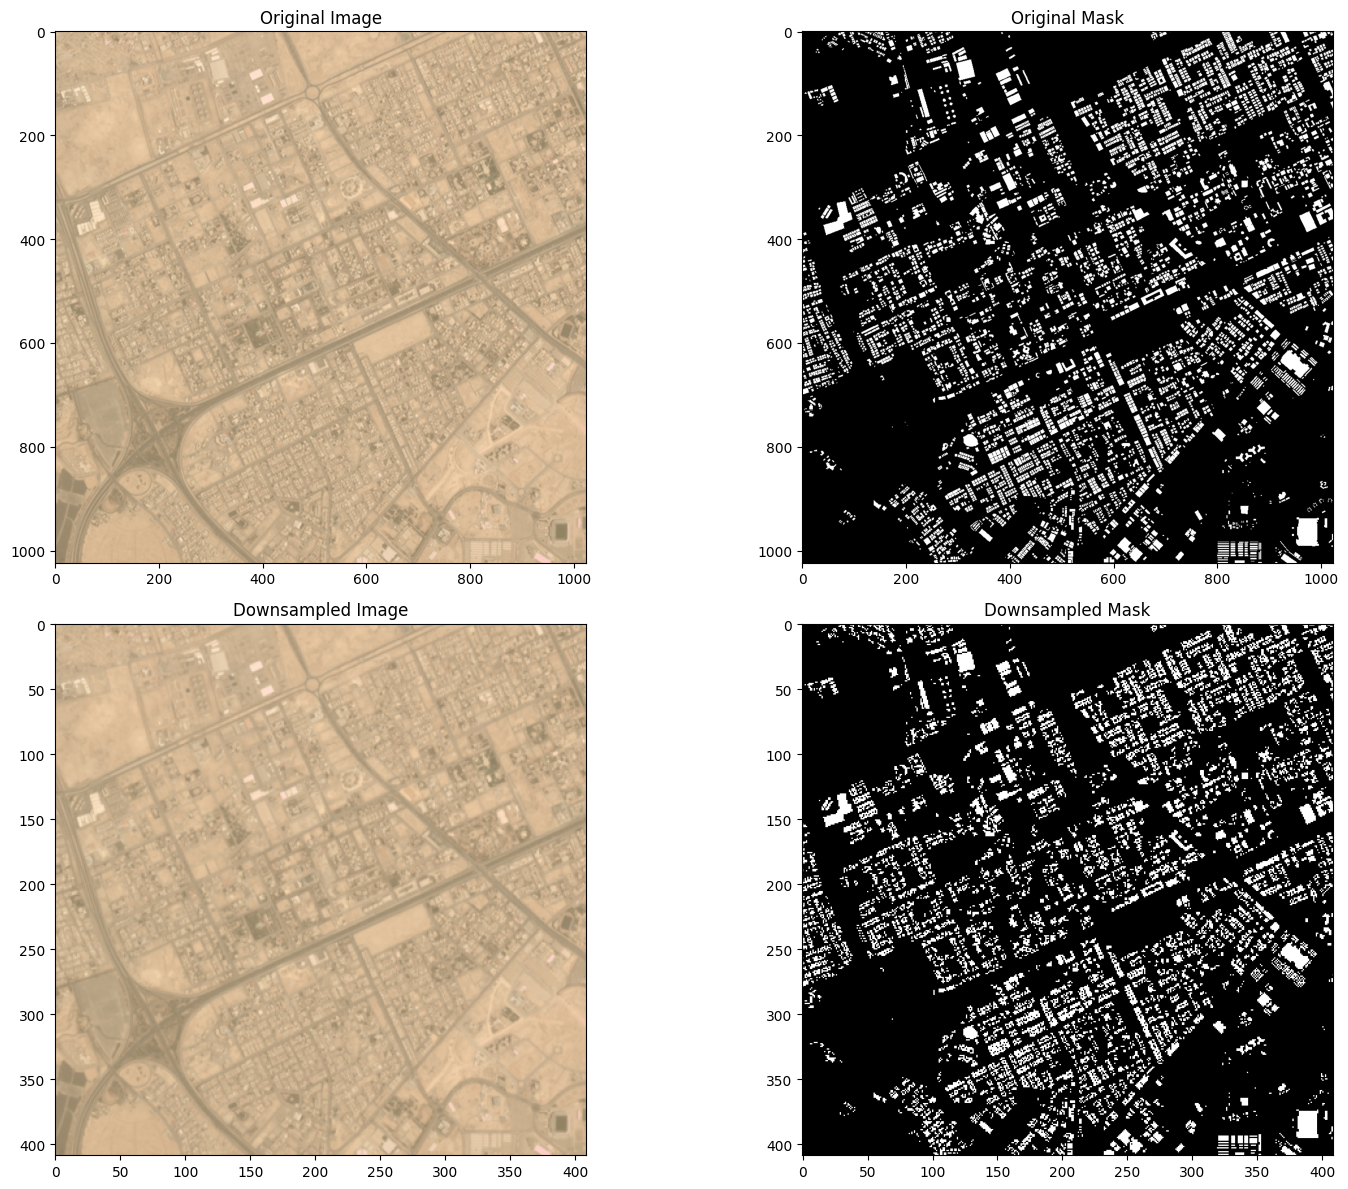

In [ ]:
import os
import skimage.io
import matplotlib.pyplot as plt
import random

# Original paths
root_dir = '/gdrive/My Drive/SpaceNet7'
original_mask_dir = '/gdrive/My Drive/Dataset/original_masks'  # Original mask path

# Downsampled paths
downsampled_image_dir = '/gdrive/My Drive/Dataset/downsampling/images'
downsampled_mask_dir = '/gdrive/My Drive/Dataset/downsampling/masks'

# Randomly select an AOI directory
aoi_dirs = [d for d in os.listdir(downsampled_image_dir) if os.path.isdir(os.path.join(downsampled_image_dir, d))]
selected_aoi = random.choice(aoi_dirs)

# List all image files within the selected AOI for the downsampled images
downsampled_image_files = os.listdir(os.path.join(downsampled_image_dir, selected_aoi))
# Randomly select an image file
selected_im_file = random.choice(downsampled_image_files)

# Construct paths for the original and downsampled image and mask
original_im_path = os.path.join(root_dir, 'train', selected_aoi, 'images_masked', selected_im_file)
original_mask_path = os.path.join(original_mask_dir, selected_im_file.replace('.tif', '_Buildings.tif'))

downsampled_im_path = os.path.join(downsampled_image_dir, selected_aoi, selected_im_file)
downsampled_mask_path = os.path.join(downsampled_mask_dir, selected_aoi, selected_im_file.replace('.tif', '_Buildings.tif'))

# Load images and masks
original_im = skimage.io.imread(original_im_path)
original_mask = skimage.io.imread(original_mask_path)
downsampled_im = skimage.io.imread(downsampled_im_path)
downsampled_mask = skimage.io.imread(downsampled_mask_path)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original Image
axes[0, 0].imshow(original_im)
axes[0, 0].set_title("Original Image")
# Keeping axes visible and displaying scale
axes[0, 0].tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)

# Original Mask
axes[0, 1].imshow(original_mask, cmap='gray')
axes[0, 1].set_title("Original Mask")
# Keeping axes visible and displaying scale
axes[0, 1].tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)

# Downsampled Image
axes[1, 0].imshow(downsampled_im)
axes[1, 0].set_title("Downsampled Image")
# Keeping axes visible and displaying scale
axes[1, 0].tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)

# Downsampled Mask
axes[1, 1].imshow(downsampled_mask, cmap='gray')
axes[1, 1].set_title("Downsampled Mask")
# Keeping axes visible and displaying scale
axes[1, 1].tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)

plt.tight_layout()
plt.show()


# Patchify And Save Image and Mask Pairs

Here, I complete the final step of the data cleaning and processing.  In this section, I patchify the downsampled imagery to extract 256x256 sized patches.  The model's input shape will reflect this size.  Once patchified, the pairs of image and label patches will be saved to the (TODO) directory.

In [ ]:
# Patchify the image and mask pairs into 256*256 patches (introduce overlapping to get even more data and reduce the 'edge effect' that can be observed from not doing so?)

# Save them for easy retrieval for EDA and Training

# https://www.youtube.com/watch?v=HrGn4uFrMOM&t=2s

In [ ]:
import os
from patchify import patchify
import skimage.io
from skimage.util import img_as_ubyte

# Directory setup
downsampled_image_dir = '/gdrive/My Drive/Dataset/downsampling/images'
downsampled_mask_dir = '/gdrive/My Drive/Dataset/downsampling/masks'
patch_image_dir = '/gdrive/My Drive/Dataset/patches/images'
patch_mask_dir = '/gdrive/My Drive/Dataset/patches/masks'

# Patch size and overlap
patch_size = 256  # Size of the patches
overlap = 128  # Overlap amount in pixels

# Ensure the target directories for patches exist
os.makedirs(patch_image_dir, exist_ok=True)
os.makedirs(patch_mask_dir, exist_ok=True)

# Function to save patches to disk
def save_patches(patches, base_path, base_name):
    for i, patch in enumerate(patches):
        for j, p in enumerate(patch):
            patch_path = os.path.join(base_path, f"{base_name}_patch_{i}_{j}.tif")
            p = img_as_ubyte(p)  # Ensure the patch is in the correct format (0-255 uint8)
            skimage.io.imsave(patch_path, p, check_contrast=False)  # Suppress low contrast warning

# Iterate over each image and corresponding mask
for aoi in sorted(os.listdir(downsampled_image_dir)):
    image_files = os.listdir(os.path.join(downsampled_image_dir, aoi))
    for image_file in image_files:
        # Construct file paths
        image_path = os.path.join(downsampled_image_dir, aoi, image_file)
        mask_path = os.path.join(downsampled_mask_dir, aoi, image_file.replace('.tif', '_Buildings.tif'))

        # Read the downsampled image and mask
        image = skimage.io.imread(image_path)
        if os.path.exists(mask_path):
            mask = skimage.io.imread(mask_path)
        else:
            print(f"[Skipping] Mask file does not exist: {mask_path}")
            continue  # Skip this iteration if the mask file doesn't exist

        # Create patches
        image_patches = patchify(image, (patch_size, patch_size, 3), step=overlap)
        mask_patches = patchify(mask, (patch_size, patch_size), step=overlap)  # Assuming mask is single-channel

        # Save patches
        save_patches(image_patches, patch_image_dir, image_file.replace('.tif', ''))
        save_patches(mask_patches, patch_mask_dir, image_file.replace('.tif', '_Buildings'))
        print(f"[Image] Patches saved for {image_path}")
        print(f"[Mask] Patches saved for {mask_path}")

[Image] Patches saved for /gdrive/My Drive/Dataset/downsampling/images/L15-0331E-1257N_1327_3160_13/global_monthly_2018_02_mosaic_L15-0331E-1257N_1327_3160_13.tif
[Mask] Patches saved for /gdrive/My Drive/Dataset/downsampling/masks/L15-0331E-1257N_1327_3160_13/global_monthly_2018_02_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.tif
[Image] Patches saved for /gdrive/My Drive/Dataset/downsampling/images/L15-0331E-1257N_1327_3160_13/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif
[Mask] Patches saved for /gdrive/My Drive/Dataset/downsampling/masks/L15-0331E-1257N_1327_3160_13/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.tif
[Image] Patches saved for /gdrive/My Drive/Dataset/downsampling/images/L15-0331E-1257N_1327_3160_13/global_monthly_2018_04_mosaic_L15-0331E-1257N_1327_3160_13.tif
[Mask] Patches saved for /gdrive/My Drive/Dataset/downsampling/masks/L15-0331E-1257N_1327_3160_13/global_monthly_2018_04_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.ti